# Quantum Chemistry VQE

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

In [2]:
H = SparsePauliOp(['XX', 'YY', 'ZZ'], coeffs=[1.+0.j, 1.+0.j, 1.+0.j])  # goal of Hamiltonian structure

In [3]:
import matplotlib.pyplot as plt
import numpy as np
!pip install pyscf==2.4.0
from pyscf import ao2mo, gto, mcscf, scf

H2 molecule

In [4]:
distance = 0.735
a=distance/2
mol = gto.Mole()
mol.build(
        verbose=0,
        atom=[
            ["H", (0, 0, -a)],
            ["H", (0, 0, a)],
        ],
        basis="sto-6g",
        spin=0,
        charge=0,
        symmetry="Dooh",
    )

In [5]:
print(mol.energy_nuc(),
      mol.energy_elec()[0],
      mol.energy_tot(),
      mol.energy_tot() - mol.energy_nuc()
      )

0.7199689944489797 -1.8455976628764188 -1.125628668427439 -1.8455976628764188


/opt/anaconda3/envs/cwq/lib/python3.13/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# VQE IBM qiskit tutorial

## 1: Generate Hamiltonian and ansatz

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

In [7]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

Ansatz = EfficientSU2 - by default linearly entangles qubits

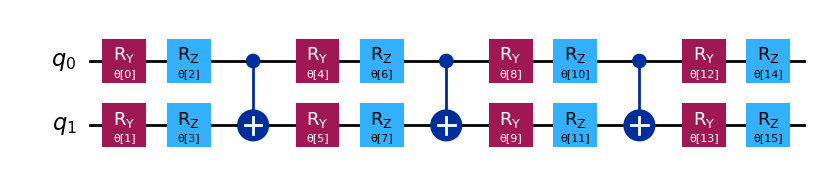

In [8]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)  #arbitrary hamiltonian - observables

ansatz = EfficientSU2(hamiltonian.num_qubits) # randomized angles for RY-RZ-CX pattern
ansatz.decompose().draw("mpl")

## 2: Optimize for execution on specific backend

Qiskit primitives only accept quantum circuit (ansatz) and Hamiltonian (observables) compatible with QPU of interest. These connectivities and instructions prepare  circuits and observables known as the instruction set architecture (ISA).

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

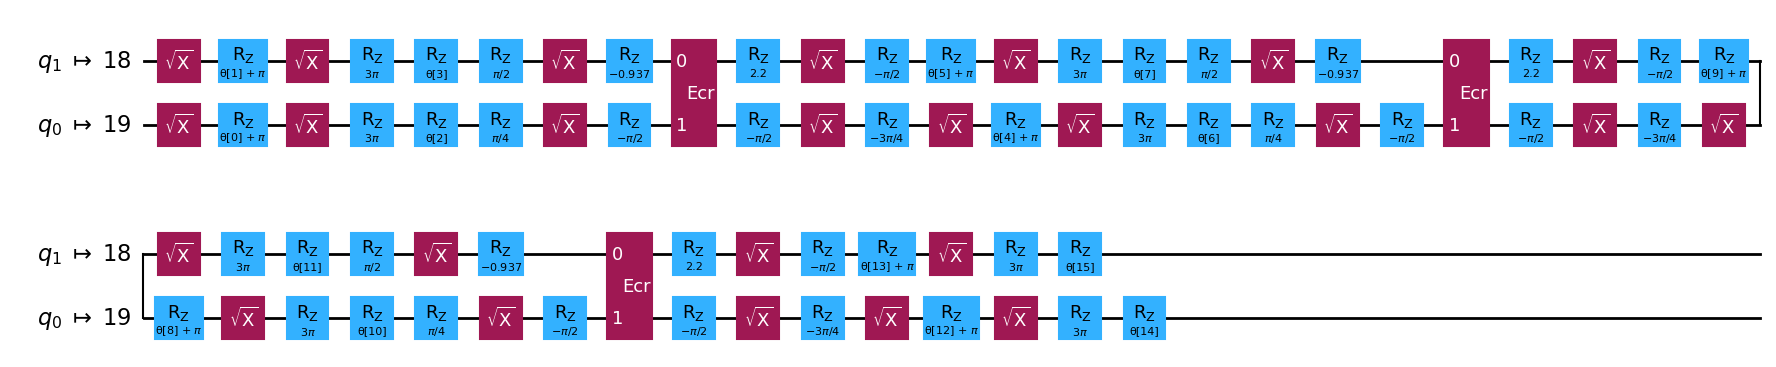

In [10]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [11]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## 3: Execute with Qiskit Primitives

In [12]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])   # primitive unified bloc (format: circuit, observables, parameters)
    result = estimator.run(pubs=[pub]).result()  # input pub into estimator
    energy = result[0].data.evs[0]  # energy estimate

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [13]:
# store current parameter vector, number of iterations, average time per iteration at each iteration in a dictionary

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [14]:
# specify random set of initial parameters for ansatz

num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [15]:
x0

array([3.79154014, 6.16108393, 1.05373256, 2.22663071, 5.04686168,
       1.13534519, 6.18479061, 4.4565188 , 5.20023504, 3.98892432,
       2.3308594 , 2.57877831, 2.15155503, 0.54060785, 2.92756427,
       2.071359  ])

: 

In [16]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",  # using cobyla routine from scipy
    )

Iters. done: 1 [Current cost: 0.16085188419826935]
Iters. done: 2 [Current cost: 0.3163324536297372]
Iters. done: 3 [Current cost: 0.13670954251752004]
Iters. done: 4 [Current cost: 0.17049452893922648]
Iters. done: 5 [Current cost: 0.10260273757781846]
Iters. done: 6 [Current cost: 0.463721639678706]
Iters. done: 7 [Current cost: -0.012558108848070171]
Iters. done: 8 [Current cost: 0.22700921535152035]
Iters. done: 9 [Current cost: 0.04706439018783629]
Iters. done: 10 [Current cost: 0.16690894719275481]
Iters. done: 11 [Current cost: -0.24016374037890492]
Iters. done: 12 [Current cost: -0.41070139493918634]
Iters. done: 13 [Current cost: -0.4506678536674649]
Iters. done: 14 [Current cost: -0.3841866455068863]
Iters. done: 15 [Current cost: -0.2776745799278929]
Iters. done: 16 [Current cost: -0.5544847492126731]
Iters. done: 17 [Current cost: -0.39349036855933406]
Iters. done: 18 [Current cost: -0.3879465502394955]
Iters. done: 19 [Current cost: -0.4854675144863534]


/opt/anaconda3/envs/cwq/lib/python3.13/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:849: UserWarning: Your current pending jobs are estimated to consume 28.92770092171574 quantum seconds, but you only have 20 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iters. done: 20 [Current cost: -0.4825657896597747]


/opt/anaconda3/envs/cwq/lib/python3.13/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:849: UserWarning: Your current pending jobs are estimated to consume 28.92770092171574 quantum seconds, but you only have 3 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iters. done: 21 [Current cost: -0.5001314831125382]


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/opt/anaconda3/envs/cwq/lib/python3.13/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
  File "/opt/anaconda3/envs/cwq/lib/python3.13/site-packages/scipy/optimize/_differentiable_functions.py", line 325, in fun
    self._update_fun()
    ~~~~~~~~~~~~~~~~^^
  File "/opt/anaconda3/envs/cwq/lib/python3.13/site-packages/scipy/optimize/_differentiable_functions.py", line 294, in _update_fun
    fx = self._wrapped_fun(self.x)
  File "/opt/anaconda3/envs/cwq/lib/python3.13/site-packages/scipy/optimize/_differentiable_functions.py", line 20, in wrapped
    fx = fun(np.copy(x), *args)
  File "/var/folders/50/l3y6wmw153d4mkrpr76gz7bm0000gn/T/ipykernel_31787/3660849712.py", line 15, in cost_func
    result 

: 

: 